# Project code

In [1]:
import numpy as np
from numpy import linalg as npl
import pandas as pd
from timeit import default_timer as timer
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss
import statsmodels.api as sm

## Generating classification dataset

In [2]:
data = make_classification(n_samples=1000,
                           n_features=20, 
                           n_informative=20, 
                           n_redundant=0, 
                           n_repeated=0, 
                           n_classes=2, 
                           n_clusters_per_class=1, 
                           flip_y=0,
                           random_state=1
                           )
#print(data)
#print(data)
X = pd.DataFrame(data[0], columns = ["x"+str(name+1) for name in range(20)])
X_with_intercept = np.asarray(sm.add_constant(X))
y = pd.DataFrame(data[1])
y = np.asarray(y)

## Defined functions for sigmoid, gradient, hessian

In [3]:
def sig(x):
    return 1/(1+np.exp(-x))

In [4]:
def grad(X, y, theta):
    prob = sig(X @ theta)
    return X.T @ (prob - y)

In [5]:
# Function for computing the Hessian matrix
def h(X, theta):
    logit = X @ theta
    entries = np.squeeze(sig(logit)*(1-sig(logit)), axis=1)
    w = np.diag(np.asarray(entries))
    h = X.T @ w @ X
    return h

## Optimization functions

In [6]:
# Function for unaltered gradient descent
def grad_descent(X, y, init_theta, eta, tol = 1e-6, max_iter=5000):
    losses = []
    start = timer()
    theta = init_theta
    losses.append(log_loss(y, sig(X @ theta)))
    for i in range(1, max_iter+1):
        # Compute the gradient of the negative-log-likelihood function at the
        # current value of the parameter estimate.
        gradl = grad(X, y, theta)
        # Update the parameter estimate
        theta = theta - eta*gradl
        # Compute the negative-log-likelihood of the current parameter estimate
        losses.append(log_loss(y,sig(X @ theta)))
        if(npl.norm(gradl) < tol):
            break
    runtime = timer() - start
    return theta, i, runtime, losses


In [7]:
# Function for gradient descent with momentum
def gd_momentum(X, y, init_theta, eta, alpha = 0.5, tol = 1e-6, max_iter=5000):
    losses = []
    start = timer()
    theta_new = init_theta
    theta = theta_new
    losses.append(log_loss(y, sig(X@theta)))
    momentum = np.zeros(np.shape(theta_new))
    for i in range(1, max_iter+1):
        # Compute the gradient of the negative-log-likelihood function at the
        # current value of the parameter estimate.
        gradl = grad(X, y, theta)
        # Update theta, including the addition of momentum
        theta_new = theta - eta*gradl + alpha*momentum
        # Calculate the new momentum term
        momentum = theta_new - theta
        theta = theta_new
        losses.append(log_loss(y,sig(X @ theta_new)))
        if(npl.norm(gradl) < tol):
            break
    runtime = timer() - start
    return theta, i, runtime, losses

In [ ]:
# Function for unaltered Newton's method. Fails to converge for many values of initial guess.
def newton(X, y, init_theta, tol = 1e-6, max_iter=100):
    losses = []
    start = timer()
    theta = init_theta
    for i in range(1, max_iter+1):
        gradl = grad(X, y, theta)
        # Update theta using Newton's method involving the Hessian matrix
        theta = theta - npl.inv((h(X,theta)) + tol*np.identity(X.shape[1])) @ gradl
        losses.append(log_loss(y,sig(X@theta)))
        if(npl.norm(gradl) < tol):
            break
    runtime = timer() - start
    return theta, i, runtime, losses

In [9]:
# Function which runs 10 iterations of gradient descent with momentum, then switches to Newton's method until convergence
def grad_then_newton(X, y, init_theta, eta, alpha=0.5, tol = 1e-6, max_iter=5000):
    losses = []
    start = timer()
    theta_new = init_theta
    theta = theta_new
    losses.append(log_loss(y, sig(X@theta)))
    momentum = np.zeros(np.shape(theta_new))
    for i1 in range(1, 11):
        gradl = grad(X, y, theta)
        theta_new = theta - eta*gradl + alpha*momentum
        momentum = theta_new - theta
        theta = theta_new
        losses.append(log_loss(y,sig(X @ theta_new)))
        if(npl.norm(gradl) < tol):
            break

    for i2 in range(11, max_iter+1):
        gradl = grad(X, y, theta)
        theta = theta - npl.inv(h(X,theta)) @ gradl
        losses.append(log_loss(y,sig(X@theta)))
        if(npl.norm(gradl) < tol):
            break

    runtime = timer() - start
    return theta, i1+i2, runtime, losses

## Computations and plotting figures

In [10]:
np.random.seed(0)
init_theta = np.random.uniform(-1,1,(21,1))

In [11]:
# Calculations of negative-log-likelihood for gradient descent with/without momentum

gd_losses_plot = [0,0,0]
_, _, _, gd_losses_plot[0] = grad_descent(X_with_intercept, y, init_theta, eta = 0.0001, tol=0)
_, _, _, gd_losses_plot[1] = grad_descent(X_with_intercept, y, init_theta, eta = 0.0005, tol=0)
_, _, _, gd_losses_plot[2] = grad_descent(X_with_intercept, y, init_theta, eta = 0.001, tol=0)

gdm_losses_plot = [0,0,0]
_, _, _, gdm_losses_plot[0] = gd_momentum(X_with_intercept, y, init_theta, eta = 0.0001, alpha = 0.5, tol=0)
_, _, _, gdm_losses_plot[1] = gd_momentum(X_with_intercept, y, init_theta, eta = 0.0005, alpha = 0.5, tol=0)
_, _, _, gdm_losses_plot[2] = gd_momentum(X_with_intercept, y, init_theta, eta = 0.001, alpha = 0.5, tol=0)



Text(0.5, 0, 'Number of iterations')

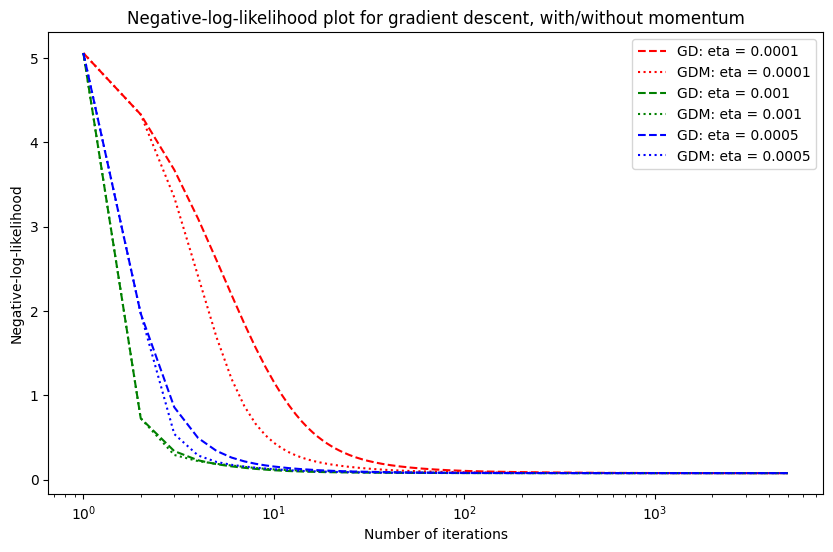

In [12]:
# Plotting Figure 1

x_range = range(1,5002)

fig, ax = plt.subplots(figsize = (10,6))
ax.set_xscale('log')

ax.plot(x_range, gd_losses_plot[0], color = "red", label = "GD: eta = 0.0001", linestyle="dashed")
ax.plot(x_range, gdm_losses_plot[0], color = "red", label = "GDM: eta = 0.0001", linestyle="dotted")

ax.plot(x_range, gd_losses_plot[2], color = "green", label = "GD: eta = 0.001", linestyle="dashed")
ax.plot(x_range, gdm_losses_plot[2], color = "green", label = "GDM: eta = 0.001", linestyle="dotted")

ax.plot(x_range, gd_losses_plot[1], color = "blue", label = "GD: eta = 0.0005", linestyle="dashed")
ax.plot(x_range, gdm_losses_plot[1], color = "blue", label = "GDM: eta = 0.0005", linestyle="dotted")


ax.legend()
ax.set_title("Negative-log-likelihood plot for gradient descent, with/without momentum")
ax.set_ylabel("Negative-log-likelihood")
ax.set_xlabel("Number of iterations")

In [13]:
# Three initial guesses with elements sampled uniformly from [-1,1]

np.random.seed(2)
init_theta1 = np.random.uniform(-1,1,(21,1))

np.random.seed(4)
init_theta2 = np.random.uniform(-1,1,(21,1))

np.random.seed(8)
init_theta3 = np.random.uniform(-1,1,(21,1))

In [14]:
# Computing negative-log-likelihood for GD w/ momentum vs. GDM + Newton

_, _, _, gdm_losses_plot[0] = gd_momentum(X_with_intercept, y, init_theta1, eta = 0.0005, alpha = 0.5, tol=0)
_, _, _, gdm_losses_plot[1] = gd_momentum(X_with_intercept, y, init_theta2, eta = 0.0005, alpha = 0.5, tol=0)
_, _, _, gdm_losses_plot[2] = gd_momentum(X_with_intercept, y, init_theta3, eta = 0.0005, alpha = 0.5, tol=0)

newton_losses = [0,0,0]

_, _, _, newton_losses[0] = grad_then_newton(X_with_intercept, y, init_theta1, eta=0.0005, tol=0)
_, _, _, newton_losses[1] = grad_then_newton(X_with_intercept, y, init_theta2, eta=0.0005, tol=0)
_, _, _, newton_losses[2] = grad_then_newton(X_with_intercept, y, init_theta3, eta=0.0005, tol=0)

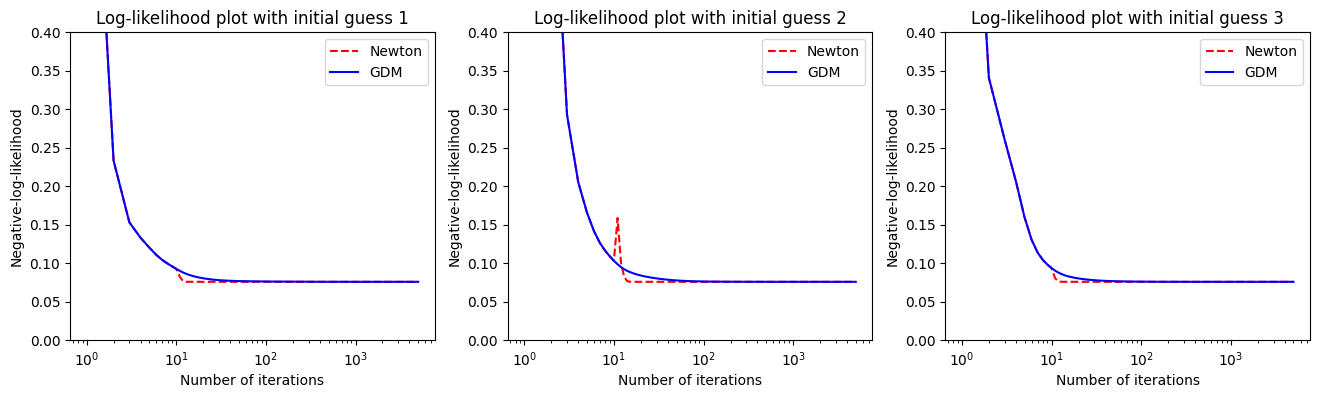

In [15]:
# Plotting Figure 2

x_range = range(1,5001)

fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i in range(0, 3):
    axes[i].set_title("Log-likelihood plot with initial guess " + str(i+1))
    axes[i].set_xscale('log')
    axes[i].set_ylabel('Negative-log-likelihood')
    axes[i].set_xlabel('Number of iterations')

for i in range(0, 3):   
    axes[i].plot(x_range, newton_losses[i][1:], color = "red", label = "Newton", linestyle="dashed")
    axes[i].plot(x_range, gdm_losses_plot[i][1:], color = "blue", label = "GDM", linestyle="solid")
    axes[i].set_ybound(0.4,0)
    axes[i].legend()

In [16]:
# Finding runtimes for convergence of GDM vs. GDM + Newton

gdm_runtimes = [0,0,0]
gdm_iters = [0,0,0]
_, gdm_iters[0], gdm_runtimes[0], _ = gd_momentum(X_with_intercept, y, init_theta1, eta = 0.0005, max_iter = 10000, alpha = 0.5, tol=1e-6)
_, gdm_iters[1], gdm_runtimes[1], _ = gd_momentum(X_with_intercept, y, init_theta2, eta = 0.0005, max_iter = 10000, alpha = 0.5, tol=1e-6)
_, gdm_iters[2], gdm_runtimes[2], _ = gd_momentum(X_with_intercept, y, init_theta3, eta = 0.0005, max_iter = 10000, alpha = 0.5, tol=1e-6)

newton_runtimes = [0,0,0]
newton_iters = [0,0,0]
_, newton_iters[0], newton_runtimes[0], _ = grad_then_newton(X_with_intercept, y, init_theta1, eta=0.0005, tol=1e-6)
_, newton_iters[1], newton_runtimes[1], _ = grad_then_newton(X_with_intercept, y, init_theta2, eta=0.0005, tol=1e-6)
_, newton_iters[2], newton_runtimes[2], _ = grad_then_newton(X_with_intercept, y, init_theta3, eta=0.0005, tol=1e-6)

In [17]:
print(gdm_runtimes)
print(gdm_iters)
print(newton_runtimes)
print(newton_iters)

[6.680071399954613, 6.490255899960175, 5.807504799973685]
[4247, 4185, 3838]
[0.058947900019120425, 0.06761040003038943, 0.05789960001129657]
[27, 29, 27]
